# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

# Finnaly, compute the camera calibration matrix and distortion coefficients 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print('Camera calibrated')

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Camera calibrated


---
## Parameters

In [2]:


# Color thresholds
s_thresh = (100,255)
l_thresh = (100,255)

# Gradient thresholds
x_thresh = (30,100)
y_thresh = (20,100)
mag_thresh = (50,150)
dir_thresh=(0.7,1.3)

# Gradient kernel sizes
x_ksize = 3
y_ksize = 3
mag_ksize = 9
dir_ksize = 15

# Sliding window properties 
nwindows=9
window_margin=60
minpix=50
search_poly_margin = 60

# Line finding parameters
num_look_back = 10
max_fails = 8

# Sanity parameters
curve_diff_threshold = 1800
lane_width_thresholds = [3,4.6]
straight_lane_min = 3000

#Convertion parameters
xm_px = 3.7/470
ym_px = 30/600

#Text
font = cv2.FONT_HERSHEY_SIMPLEX
lineType = 2

---
## Helper functions

In [3]:

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def undistort(img):
    """Applies a distortion correction to raw images"""
    return cv2.undistort(img, mtx, dist)


def abs_sobel_threshold(gray, ksize, thresh, orient='x'):
    """Calculate directional gradient and apply threshold"""
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    elif orient=='y': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    else: 
        print("Unknown orient for abs_sobel_treshold")
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output


def mag_threshold(gray, ksize, thresh):
    """Calculate gradient magnitude and apply threshold"""
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * mag / np.max(mag))
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output


def dir_threshold(gray, ksize, thresh):
    """Calculate gradient direction and apply threshold"""
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



def apply_thresholds(img, s_thresh, x_thresh, x_ksize, y_thresh, y_ksize, mag_thresh, mag_ksize, dir_thresh, dir_ksize):
    """
    Applies and combines thresholds on image gradients and saturation channel to retrieve
    a binary image containing lanes
    """
    img = np.copy(img)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #Threshold directional gradients
    gradx = abs_sobel_threshold(l_channel, x_ksize, x_thresh, orient='x')
    grady = abs_sobel_threshold(l_channel, y_ksize, y_thresh, orient='y')
    
    
    #Threshold gradient magnitude
    mag_binary = mag_threshold(l_channel, mag_ksize, mag_thresh)
    
    #Threshold gradient direction
    dir_binary = dir_threshold(l_channel,dir_ksize,dir_thresh)
    
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary==1) & (dir_binary==1))] = 1 
 
    # Threshold color channel
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel with different colors
    color = np.dstack(( np.zeros_like(color_binary), color_binary, combined)) * 255
    
    # Binary
    binary = np.zeros_like(gradx)
    binary[((color_binary==1) | (combined==1))] = 1
    
    return color, binary 
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def fit(img_shape, x, y, real=False):
    """
    Calculates a second degree function approximation for the data.

    Returns funcion coeffisients and function. Converts from pixel values to meters if
    'real' is true.
    """
    if real:
        coef =  np.polyfit(y*ym_px, x*xm_px, 2)
    else:
        coef = np.polyfit(y,x,2)
    
    f = np.poly1d(coef)
    
    
    return coef, f
    


def transform_perspective(img):
    """
    Applies an image bird-view image transformation
    """
    src = np.float32([[570,465],[720,465],[273,665],[1033,665]])
    xmax =img.shape[1]
    ymax=img.shape[0]
    dst = np.float32([[xmax*0.3, ymax*0.3], [xmax*0.7, ymax*0.3],[xmax*0.3, ymax*0.98],[xmax*0.7, ymax*0.98]])
    # M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Minv, the inverse perspective transform 
    # warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (xmax,ymax), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def project_lanes_onto_original_image(shape, undist, binary_warped, left_x, right_x, y, Minv): 
    """
    Uses the inverse bird-view transformation to draw the lanes onto the image
    """
    if left_x is None or right_x is None:
        return undist
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (shape[1], shape[0])) 
    # Combine the result with the original image
    original_image_with_lanes = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Return original image with detected lanes 
    return original_image_with_lanes

def measure_curvature(y_eval, coef):
    """
    Calculate the curvature of polynomial functions in pixels, using the formula:
    R = (1+(f'(y))^2)^(3/2) / |f''(y)|
    f(y) = Ay^2 + By + C
    """
    
    return np.power((1+np.power((2*coef[0]*y_eval+coef[1]),2)),(3/2))/np.abs(2*coef[0]) 
    


def get_lane_width(left_E_x, right_E_y):
    """
    Measures the distance between the lines at the bottom, middle and top of the road,
    returning the average distance from the three points
    """
    l = len(left_E_x)
    width_low = right_E_y[-1]-left_E_x[-1]
    width_middle = right_E_y[l//2]-left_E_x[l//2]
    width_high = right_E_y[0]-left_E_x[0]

    average_length = np.mean([width_low, width_middle, width_high])
    min_length = min(width_low, width_middle, width_high)
    max_length = max(width_low, width_middle, width_high)

    return average_length*xm_px, min_length*xm_px, max_length*xm_px

def sanity_check(left_curverad, right_curverad, min_width, max_width, left_coef, right_coef):
    """
    Performs a sanity check on two lines, evaluating avg distance and similarity in curvature 
    Returns True if the lines make sense , or False if they dont make sende
    """
    
    left_curverad = min(straight_lane_min, left_curverad)
    right_curverad = min(straight_lane_min, right_curverad)
    
    if abs(left_curverad-right_curverad) > curve_diff_threshold:
        #print('Not valid data, curverad difference')
        return False
    
    if min_width < lane_width_thresholds[0] or max_width > lane_width_thresholds[1]:
        #print('Not valid data, minimum lane width')
        return False

    return True

--- 
## Line Class

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.not_detected = 0
        
        # Stores coefficients
        self.last_fits = []
        self.best_fit = None
        self.current_fit = None
        
        # Stores x values
        self.last_xs = []
        self.best_x = None
        self.current_x = None
        
        # Stores curvatures
        self.last_curverads = []
        self.best_curverad = None
        self.current_curverad = None
        
        self.valid = False
        
        
    def reset(self):
        self.__init__()


    def update(self, x, fit, curverad, sanity):
        self.current_fit = fit
        self.current_x = x
        self.current_curverad = curverad
        
        if not sanity:
            self.not_detected += 1
        else:
            self.valid=True
            
            # Store valid measurments
            self.last_fits.append(fit)
            self.last_xs.append(x)
            self.last_curverads.append(curverad)
            
            if len(self.last_fits)>=num_look_back:
                self.last_fits.pop(0)
                self.last_xs.pop(0)
                self.last_curverads.pop(0)
            
            # Calculate best (average) values
            self.best_fit = np.mean(self.last_fits, axis=0)
            self.best_x = np.mean(self.last_xs, axis=0)
            self.best_curverad = np.mean(self.last_curverads)
      
        if self.not_detected > max_fails:
            
            self.reset()
            return False
        
        return True
    
    def get_fit(self):
        if self.best_fit is None:
            return self.current_fit
        return self.best_fit

    def get_x(self):
        if self.best_x is None:
            return self.current_x
        return self.best_x

    def get_curverad(self):
        if self.best_curverad is None:
            return self.current_curverad
        return self.best_curverad

--- 
## Finding Lanes 

In [5]:
def sliding_windows(img, nwindows, margin, minpix, debug=False ):
    """Using peaks in histogram to find the starting points of the lanes 
    and then using sliding windows to find the positions of the rest of the left and right lane pixels"""
    

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if debug:
        out_img = np.dstack((img, img, img))
        
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if(debug):
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
  
            

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if debug:
        out_img[lefty,leftx] = [255,0,0]
        out_img[righty,rightx] = [0,0,255]
        print("Sliding windows:")
        plt.imshow(out_img)
        plt.show()
        
    return leftx, lefty, rightx, righty 


def search_around_poly(img, left_fit,right_fit, margin, debug=False):

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    # Find search area of actuvated x-values, within the margin of the polynomial function
    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy) + left_fit[2] - margin) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy) + left_fit[2] + margin))
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy) + right_fit[2] - margin) &
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy) + right_fit[2] + margin))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    if debug: 
        ## Visualization ##
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_f = np.poly1d(left_fit)
        right_f = np.poly1d(right_fit)
        left_fitx = left_f(ploty)
        right_fitx = right_f(ploty)

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        print("Search around poly debug")
        plt.imshow(result)
        plt.show()
    
        ## End visualization steps ##

    return leftx, lefty, rightx, righty

def find_lane_pixels(img, nwindows, margin_window, margin_poly_search, minpix, debug=False):
    """ Returns the x and y coordinates for pixels believed to belong to the left and right lane"""
    
    if left_line.valid and right_line.valid:
        leftx, lefty, rightx, righty =  search_around_poly(img,left_line.get_fit(),right_line.get_fit(), margin_poly_search, debug=debug)
    else:
        # Finding lane pixels 
        leftx, lefty, rightx, righty = sliding_windows(img, nwindows, margin_window, minpix, debug=debug)

    return leftx, lefty, rightx, righty




---
## Main pipeline

In [6]:
import time

def process_image(img, debug=False):
    """
    Takes the original image, and returns it with the detected lanes drwan onto it. 
    This is done by: undistorting image, applying color and gradient tresholds, selecting region of interest, 
    performing perspective transform,  detecting lanes, transforming lanes back to original image 
    and drawing them onto original image
    """
    
    if debug:
        print('0. Raw image')
        plt.imshow(img)
        plt.show()
        
    
    # Undistort image
    undist = undistort(img)
    
    if debug:
        print('1. Undistorted image')
        plt.imshow(undist)
        plt.show()
    
        
    # Apply the image transormations
    stacked, binary = apply_thresholds(undist, s_thresh, x_thresh, x_ksize, y_thresh, y_ksize, mag_thresh, mag_ksize, dir_thresh, dir_ksize)
    
    y_max = img.shape[0]
    x_max = img.shape[1]
    # Defines the region of interest
    vertices = np.array([[(x_max*0.15, y_max), (x_max * 0.45, y_max * 0.59), (x_max * 0.55, y_max * 0.59), (x_max*1, y_max)]], dtype=np.int32)
    binary = region_of_interest(img=binary, vertices=vertices)
    
    if debug:
        print('2. Stacked thresholds (blue = gradient, green = color)')
        plt.imshow(stacked)
        plt.show()
        
        print('2. Binary thresholds (masked)')
        plt.imshow(binary, cmap="gray")
        plt.show()
    
    # Transformes the images
    warped, M, Minv = transform_perspective(undist)
    warped_binary, M, Minv = transform_perspective(binary)

    if debug:
        print('3. Perspective change: warped')
        plt.imshow(warped)
        plt.show()
        print('3. Perspective change: warped binary')
        plt.imshow(warped_binary, cmap ="gray")
        plt.show()
            
    # Generate y values for pixel world
    y_px = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    cont = False
    
    # If the poly search are unsuccesfull (sanity checks fails), the loop re-runs with sliding window
    while not cont:

        # Retrieve lane pixels
        left_x, left_y, right_x, right_y = find_lane_pixels(warped_binary, nwindows, window_margin, search_poly_margin, minpix, debug=debug)

        # Calculate fit in both pixel world and real world, the first returned value is the
        # function coefficients, while the second value is the actual function
        left_coef_px, left_f_px = fit(warped_binary.shape, left_x, left_y)
        left_coef_m, left_f_m = fit(warped_binary.shape, left_x, left_y, real=True)

        right_coef_px, right_f_px = fit(warped_binary.shape, right_x, right_y)
        right_coef_m, right_f_m = fit(warped_binary.shape, right_x, right_y,real=True)

        # Generate expected x values for the pixel world
        left_Ex_px = left_f_px(y_px)
        right_Ex_px = right_f_px(y_px)

        # Calculate curvature in real world
        y_eval = y_px[-1]*ym_px
        left_curverad = measure_curvature(y_eval, left_coef_m)
        right_curverad = measure_curvature(y_eval, right_coef_m) 

        # Get lane width
        avg_width, min_width, max_width = get_lane_width(left_Ex_px, right_Ex_px)


        #Check sanity of measurements
        sanity = sanity_check(left_curverad, right_curverad, min_width, max_width, left_coef_px, right_coef_px)

        cont = left_line.update(left_Ex_px, left_coef_px, left_curverad, sanity)
        cont = right_line.update(right_Ex_px, right_coef_px, right_curverad, sanity) and cont
        
    
    
    if debug:
        print("6. Fit Lines (red = this frame, blue = lookback averaged)")
        
        plt.plot(left_Ex_px, y_px, color="red")
        plt.plot(right_Ex_px, y_px, color="red")
        plt.plot(left_line.get_x(), y_px, color="blue")
        plt.plot(right_line.get_x(), y_px, color="blue")
        plt.imshow(warped)
        plt.show()
        
    img_with_lanes = project_lanes_onto_original_image(warped_binary.shape, undist, warped_binary, left_line.get_x(), right_line.get_x(), y_px, Minv)

    avg_curve = (left_line.get_curverad()+right_line.get_curverad())/2
    
    if avg_curve < straight_lane_min:
        cv2.putText(img_with_lanes, 'Curve: %.2f m' % avg_curve, (450,200), font, 1.5,(0,0,0),lineType)
    else:
        cv2.putText(img_with_lanes, 'Curve: - m', (450,200), font, 1.5,(0,0,0),lineType)

    cv2.putText(img_with_lanes, 'Lane width: %.2f m' % avg_width, (450,100), font, 1.5,(0,0,0),lineType)

    if debug: 
        
        print('5. Original image with detected lanes')
    

    return img_with_lanes
    #return warped_binary, undist, left_fitx, right_fitx, ploty
    

---
## Test on images

0. Raw image


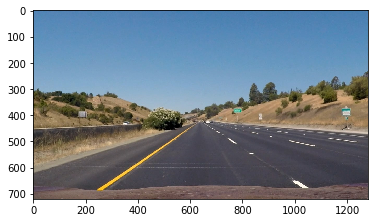

1. Undistorted image


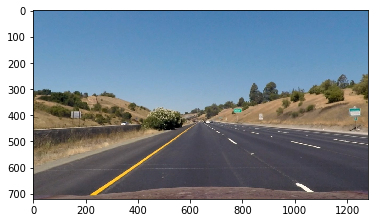

2. Stacked thresholds (blue = gradient, green = color)


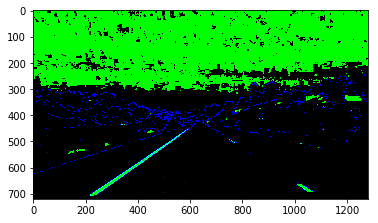

2. Binary thresholds (masked)


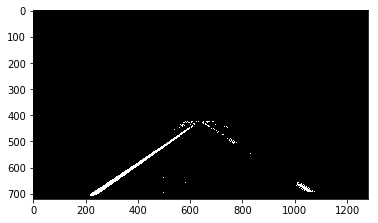

3. Perspective change: warped


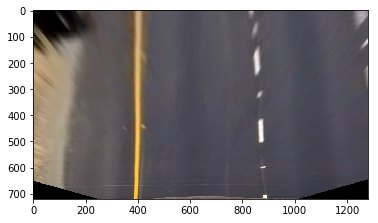

3. Perspective change: warped binary


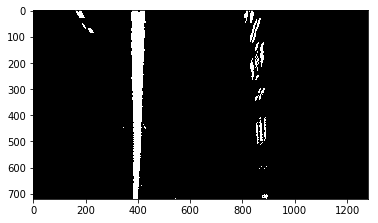

Sliding windows:


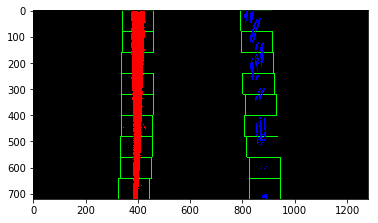

6. Fit Lines (red = this frame, blue = lookback averaged)


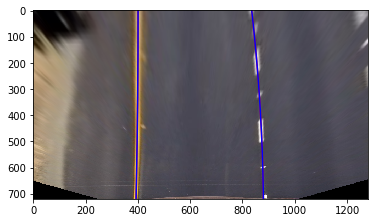

5. Original image with detected lanes


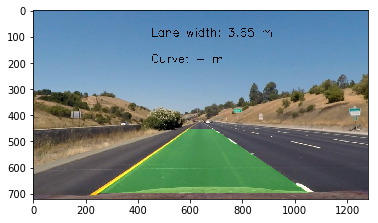

---------------------------------------------------
0. Raw image


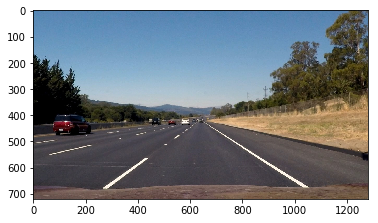

1. Undistorted image


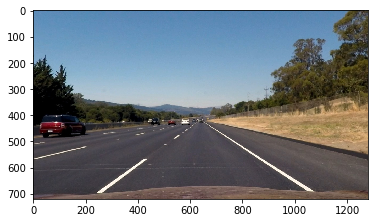

2. Stacked thresholds (blue = gradient, green = color)


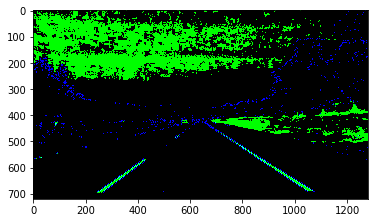

2. Binary thresholds (masked)


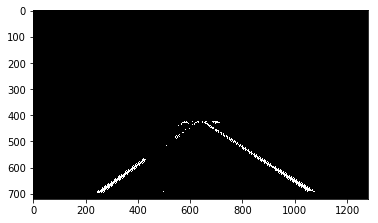

3. Perspective change: warped


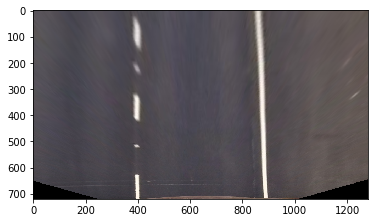

3. Perspective change: warped binary


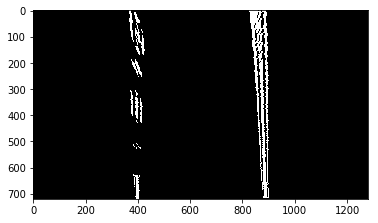

Sliding windows:


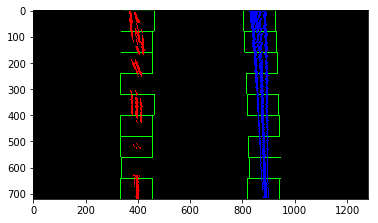

6. Fit Lines (red = this frame, blue = lookback averaged)


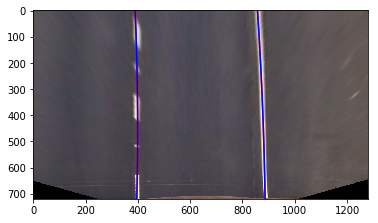

5. Original image with detected lanes


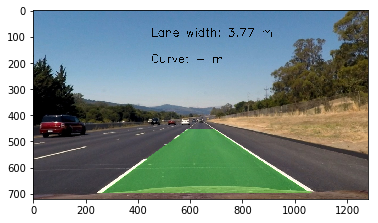

---------------------------------------------------
0. Raw image


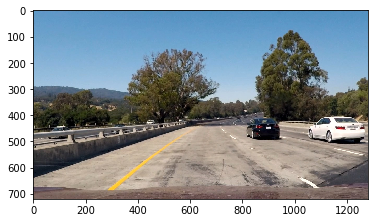

1. Undistorted image


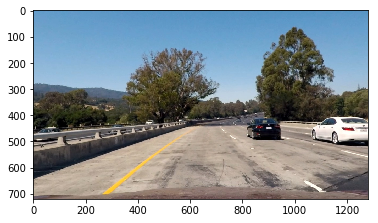

2. Stacked thresholds (blue = gradient, green = color)


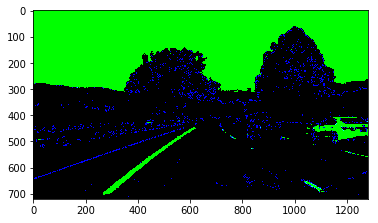

2. Binary thresholds (masked)


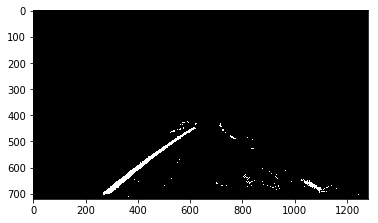

3. Perspective change: warped


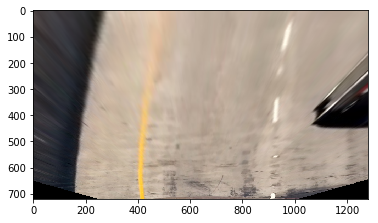

3. Perspective change: warped binary


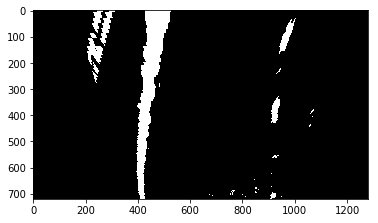

Sliding windows:


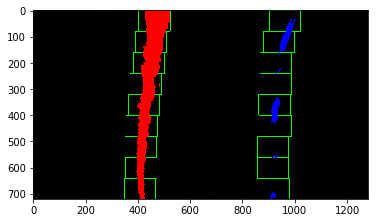

6. Fit Lines (red = this frame, blue = lookback averaged)


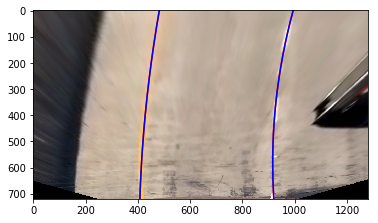

5. Original image with detected lanes


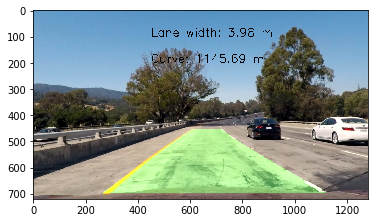

---------------------------------------------------
0. Raw image


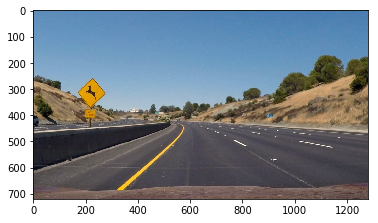

1. Undistorted image


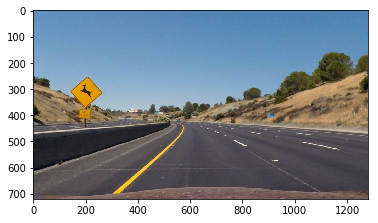

2. Stacked thresholds (blue = gradient, green = color)


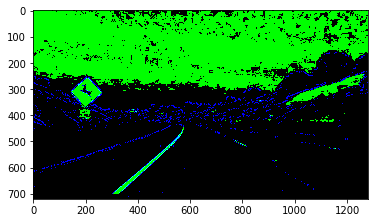

2. Binary thresholds (masked)


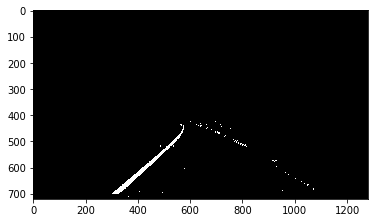

3. Perspective change: warped


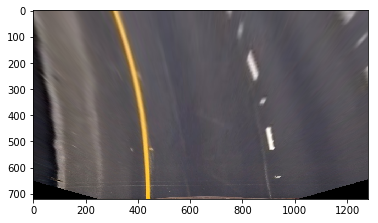

3. Perspective change: warped binary


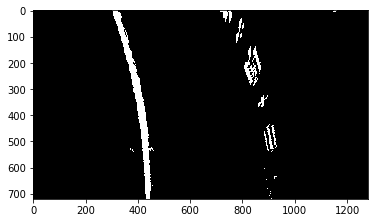

Sliding windows:


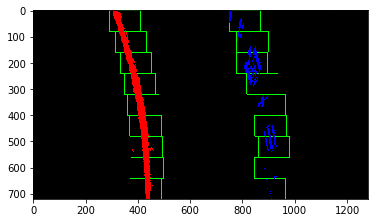

6. Fit Lines (red = this frame, blue = lookback averaged)


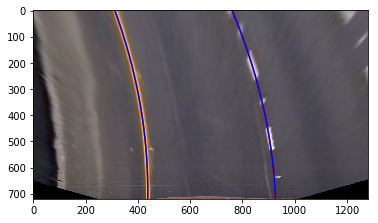

5. Original image with detected lanes


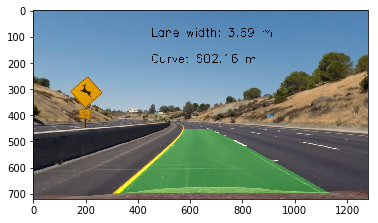

---------------------------------------------------
0. Raw image


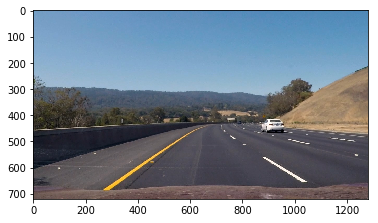

1. Undistorted image


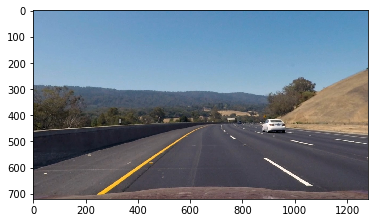

2. Stacked thresholds (blue = gradient, green = color)


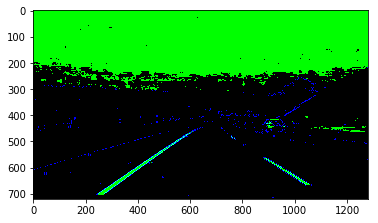

2. Binary thresholds (masked)


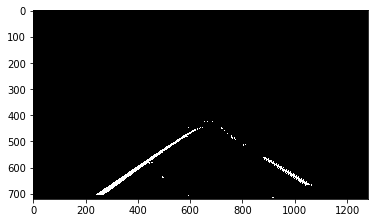

3. Perspective change: warped


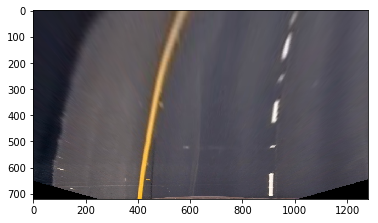

3. Perspective change: warped binary


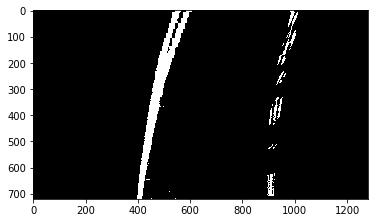

Sliding windows:


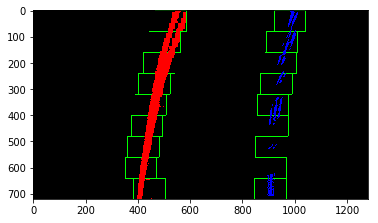

6. Fit Lines (red = this frame, blue = lookback averaged)


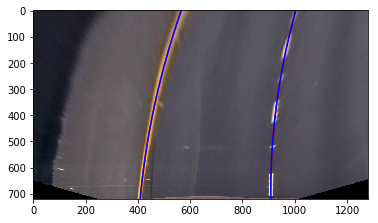

5. Original image with detected lanes


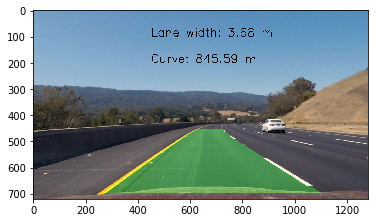

---------------------------------------------------
0. Raw image


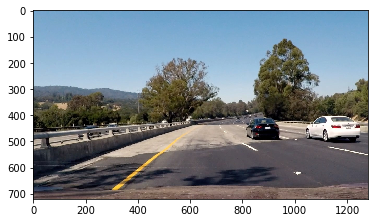

1. Undistorted image


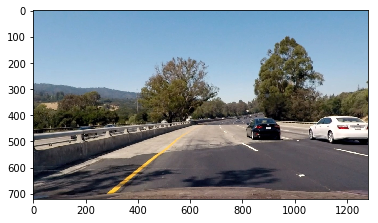

2. Stacked thresholds (blue = gradient, green = color)


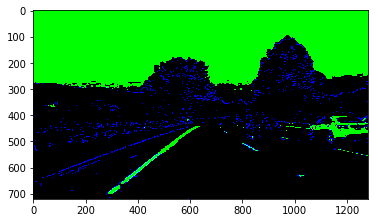

2. Binary thresholds (masked)


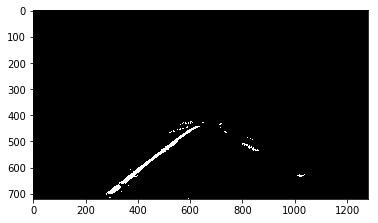

3. Perspective change: warped


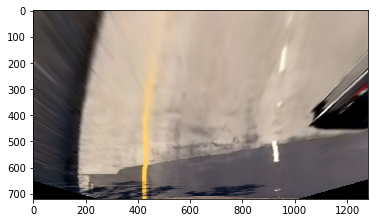

3. Perspective change: warped binary


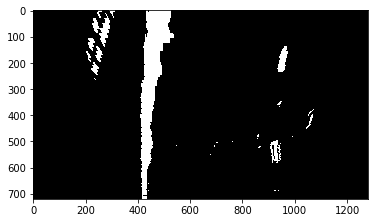

Sliding windows:


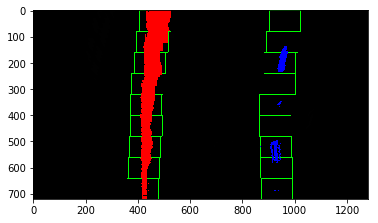

6. Fit Lines (red = this frame, blue = lookback averaged)


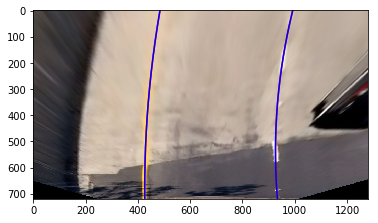

5. Original image with detected lanes


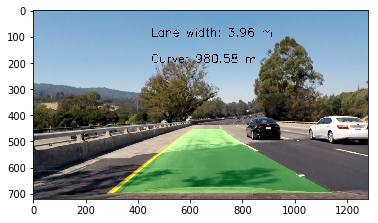

---------------------------------------------------
0. Raw image


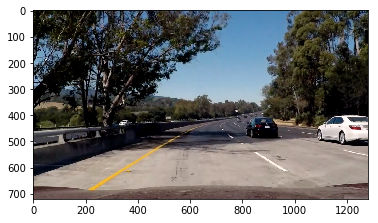

1. Undistorted image


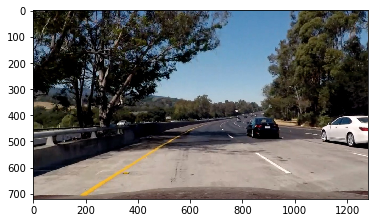

2. Stacked thresholds (blue = gradient, green = color)


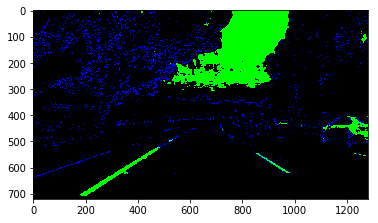

2. Binary thresholds (masked)


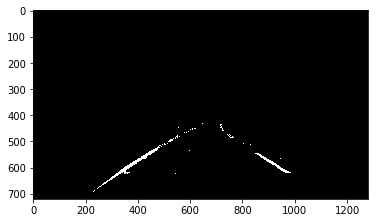

3. Perspective change: warped


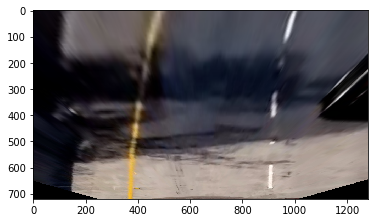

3. Perspective change: warped binary


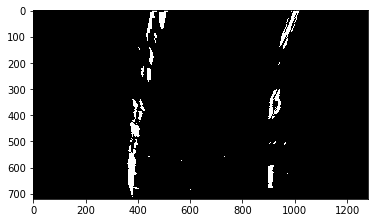

Sliding windows:


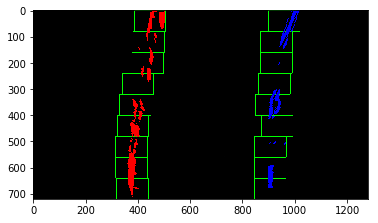

6. Fit Lines (red = this frame, blue = lookback averaged)


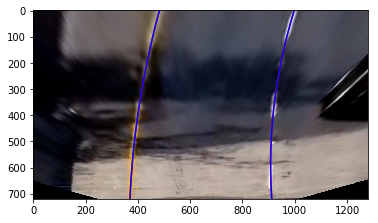

5. Original image with detected lanes


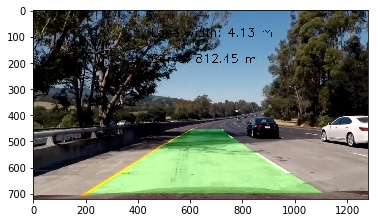

---------------------------------------------------
0. Raw image


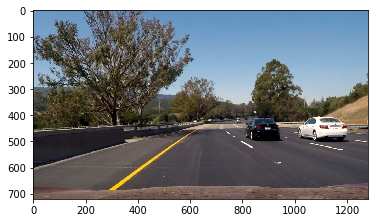

1. Undistorted image


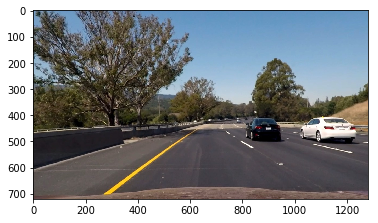

2. Stacked thresholds (blue = gradient, green = color)


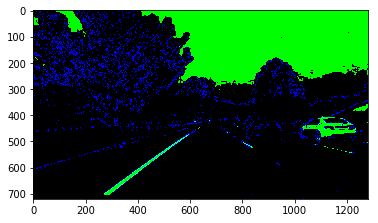

2. Binary thresholds (masked)


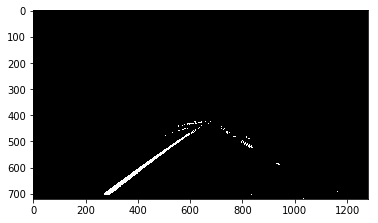

3. Perspective change: warped


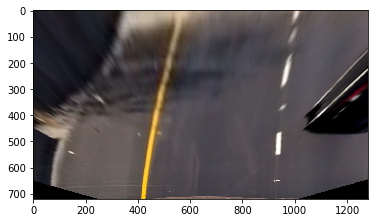

3. Perspective change: warped binary


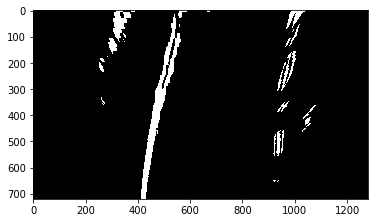

Sliding windows:


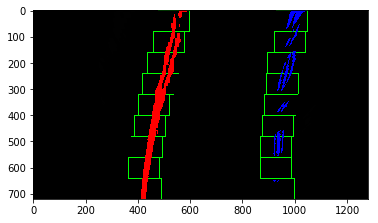

6. Fit Lines (red = this frame, blue = lookback averaged)


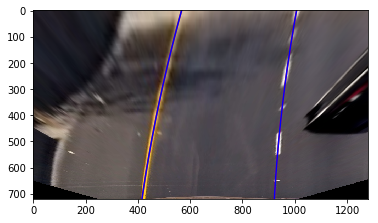

5. Original image with detected lanes


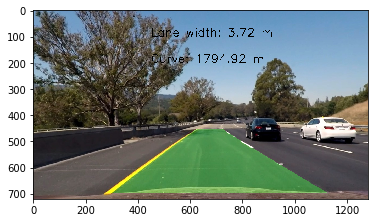

---------------------------------------------------


In [7]:

images = sorted(glob.glob('./test_images/*.jpg'))

# Iterate over all test images and show the detected lanes 
for fname in images:
    left_line = Line()
    right_line = Line()

    img = mpimg.imread(fname)
    img_with_lanes = process_image(img, debug=True)
    plt.imshow(img_with_lanes)
    plt.show()
    print("---------------------------------------------------")
    
    plt.imsave(fname.replace("test_images","output_images"), img_with_lanes );



---
## Test on videoes

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


left_line = Line()
right_line = Line()

video = "project_video.mp4"
clip1_output = "test_videos_output/"+video
clip1 = VideoFileClip(video)
clip1_processed = clip1.fl_image(process_image) 


%time clip1_processed.write_videofile(clip1_output, audio=False)



[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


 98%|█████████▊| 1236/1261 [05:01<00:06,  4.00it/s]

In [ ]:

# Play yhe video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip1_output))

---
## Improved Lane Search 